# Shoppers Purchasing Intention Prediction using ANN


---



## 1. Data Load & Importing Libraries

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sys

from scipy import stats
from scipy.stats import boxcox

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix

import xgboost as xgb
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 2. Data Preprocessing

In [4]:
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues' , 'SpecialDay' , 'Weekend']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']

In [5]:
# Check the balance of the target variable 'Revenue'
print("\nDistribution of the target variable 'Revenue':")
print(df['Revenue'].value_counts(normalize=True))


Distribution of the target variable 'Revenue':
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
df['Weekend'].replace({True: 1, False: 0}, inplace=True)

In [8]:
df.loc[:,['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('int64').astype('object')

In [9]:
# We get rid of duplicated data
df.drop_duplicates(inplace=True, keep='first')
df.duplicated().sum(), df.shape

(0, (12205, 18))

In the dataset we have identified `125 rows` that are duplicated. Since these are exact replicas, we will eliminate them.


---



## 3. Exploratory Data Analysis

### EDA - Univariate Analysis

In [10]:
print(numerical_features)
print("\n")
print(categorical_features)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend']


['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']


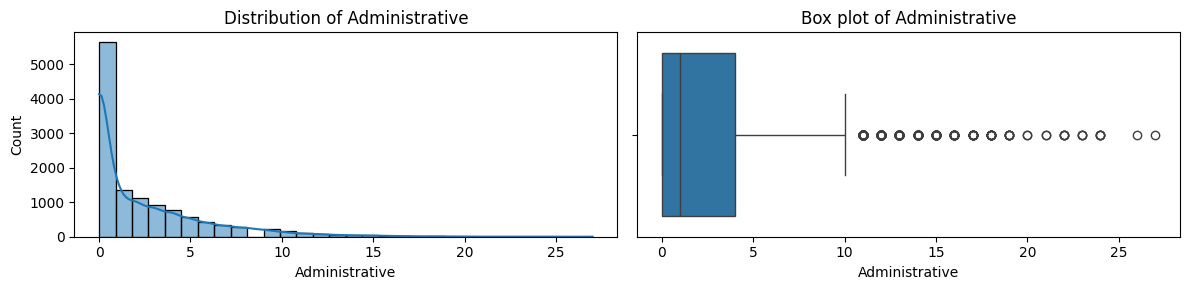

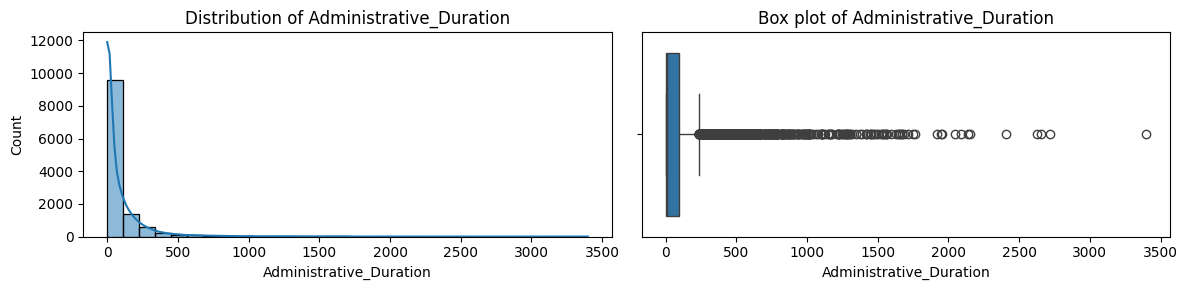

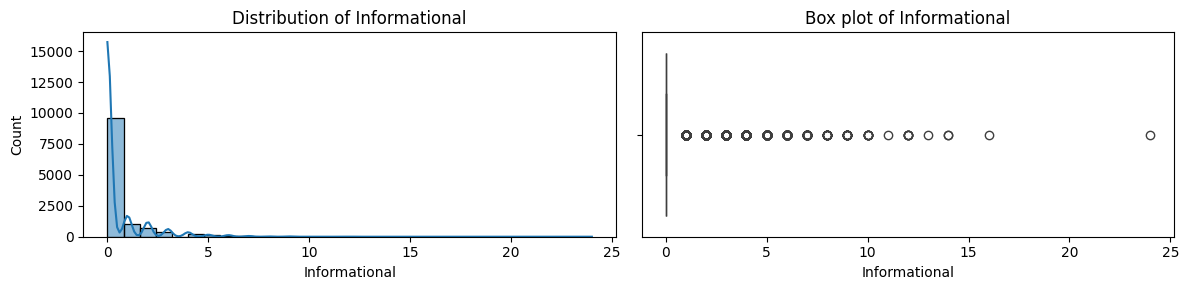

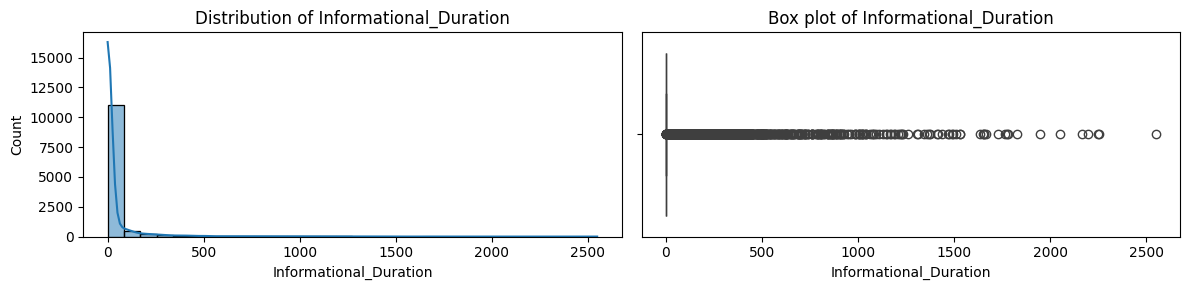

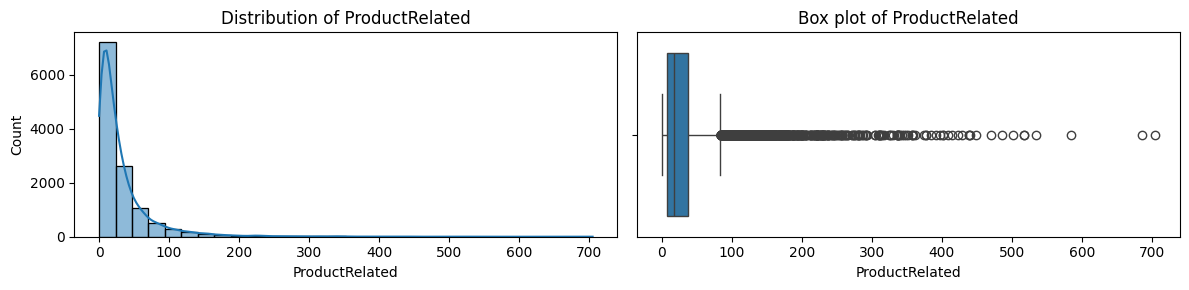

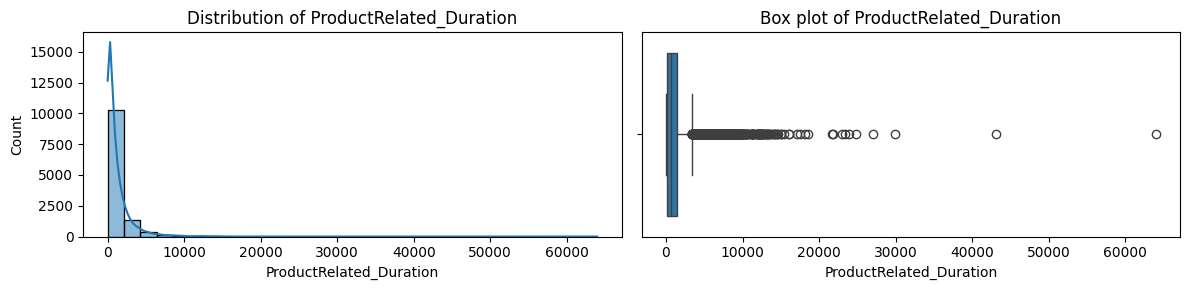

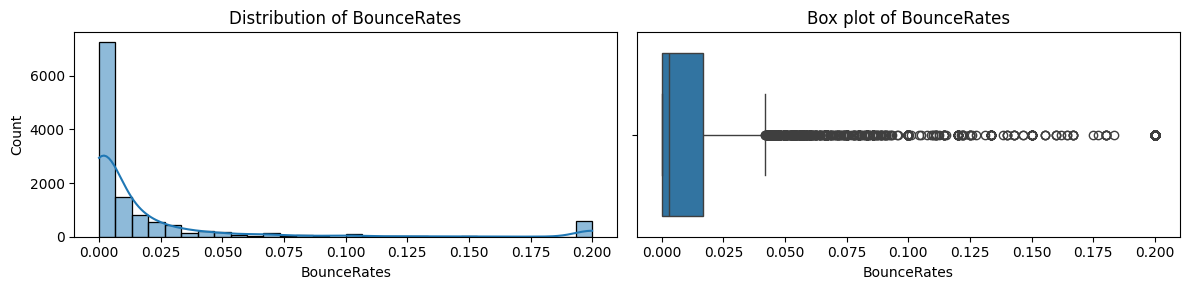

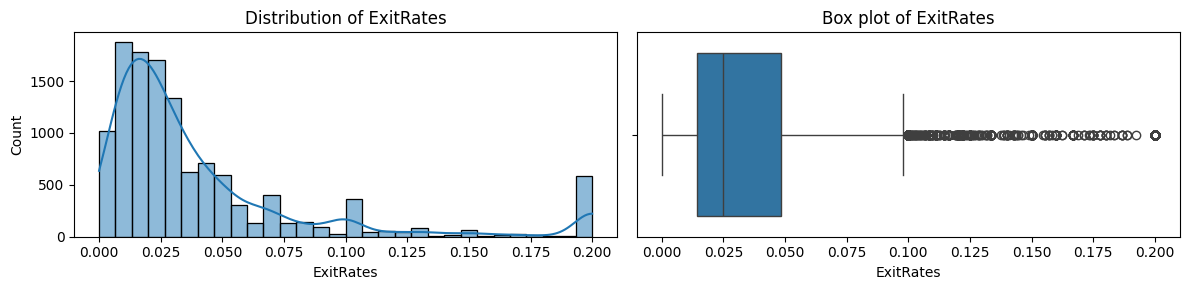

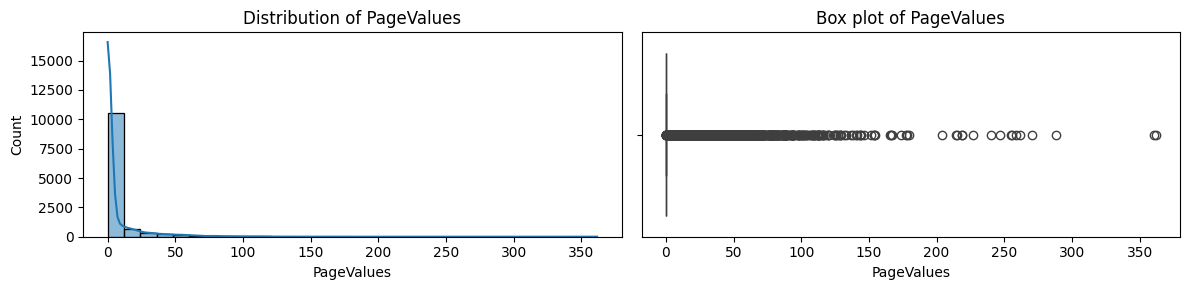

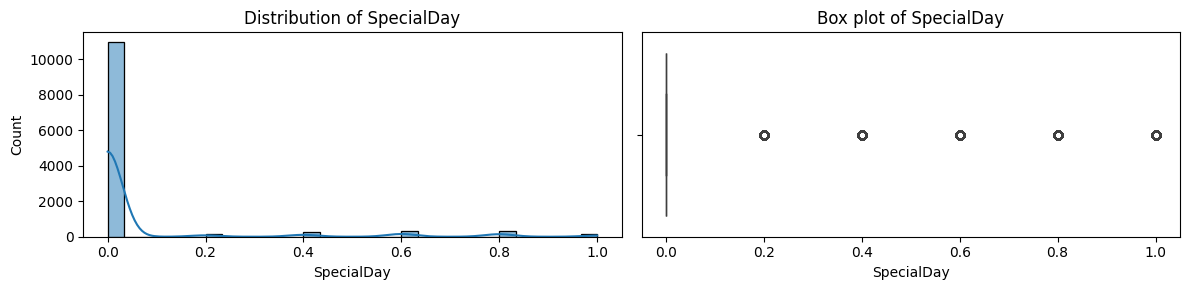

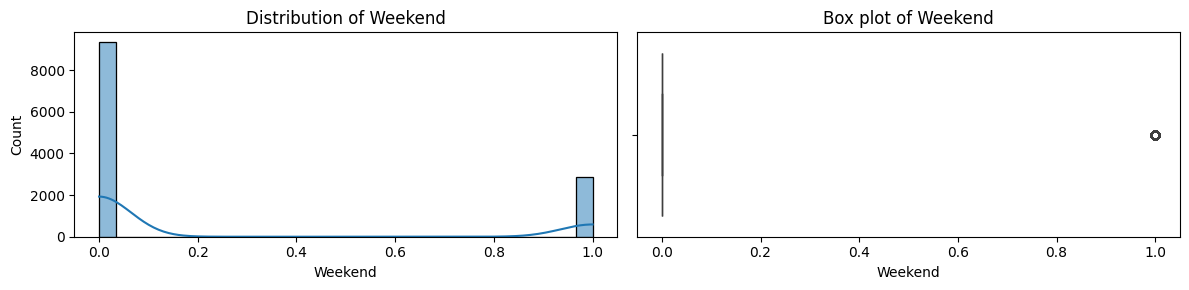

In [11]:
# Univariate Analysis - Numerical Features

# Plotting histplot and boxplot in one row for each numerical feature
for feature in numerical_features:
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    # Histplot on the left
    sns.histplot(df[feature], kde=True, ax=axs[0], bins = 30)
    axs[0].set_title(f'Distribution of {feature}')

    # Boxplot on the right
    sns.boxplot(x=df[feature], ax=axs[1])
    axs[1].set_title(f'Box plot of {feature}')

    plt.tight_layout()
    plt.show()

### **Distribution Analysis of Website Metrics**

#### **Administrative Pages:**
- The majority of sessions have a very low number of administrative pages viewed, typically between 0 and 5.
- There are very few sessions with more than 5 administrative page views.

#### **Administrative Duration:**
- Most sessions have a short administrative duration, predominantly between 0 and 500 seconds.
- Very few sessions exceed this duration.

#### **Informational Pages:**
- Similar to administrative page views, most sessions have a low count of informational page views, usually between 0 and 5.
- Sessions with more than 5 informational page views are rare.

#### **Informational Duration:**
- The informational duration is also mostly short, typically between 0 and 500 seconds.
- Longer durations are much less common.

#### **Product-Related Pages:**
- The distribution shows that most sessions have a small number of product-related page views, commonly between 0 and 100.
- A significant drop is observed after 100 product-related page views.

#### **Product-Related Duration:**
- Most sessions have a short duration spent on product-related pages, predominantly between 0 and 10000 seconds.
- There are very few sessions with a duration exceeding this range.

#### **Bounce Rates:**
- The bounce rates are highly skewed towards the lower end, with most sessions having a bounce rate between 0 and 0.05.
- Bounce rates higher than 0.1 are less frequent, with a notable peak near 0.2.

#### **Exit Rates:**
- The exit rates are more evenly distributed compared to bounce rates.
- There is a peak in the 0.025 to 0.05 range, with another peak near 0.2, indicating multiple modes in the distribution.

#### **Page Values:**
- The majority of sessions have low page values, commonly between 0 and 50.
- There are very few sessions with high page values, leading to a steep drop after the initial peak.

### **General Conclusions:**
- Skewed Distributions: Most distributions are right-skewed, indicating that a large proportion of sessions have low values for these variables, with fewer sessions having higher values.
- User Behavior: Users generally engage minimally with administrative and informational pages and spend relatively short durations on them. Most user interactions seem to be concentrated in shorter time frames and fewer pages.
- Bounce and Exit Rates: Bounce rates are heavily skewed towards lower values, suggesting that many sessions have low bounce rates. However, exit rates show a more varied distribution, indicating different user behaviors in leaving the site.
- Page Value: The low page values for most sessions suggest that high-value pages are not commonly reached or interacted with by the majority of users.
These distributions can help inform strategies for improving user engagement and understanding user behavior on the website.



---



### Based on the distribution analysis:

- **Administrative and Informational Metrics**: Low counts and short durations suggest minimal impact on revenue prediction.
- **Product-Related Metrics**: Despite majority having low counts and durations, a significant drop after a threshold indicates potential relevance.
- **Bounce and Exit Rates**: Skewed distributions indicate varying user behaviors; both are valuable for understanding engagement and site abandonment.
- **Page Values**: Majority have low values, suggesting limited interaction with high-value pages.

<Axes: xlabel='OperatingSystems'>

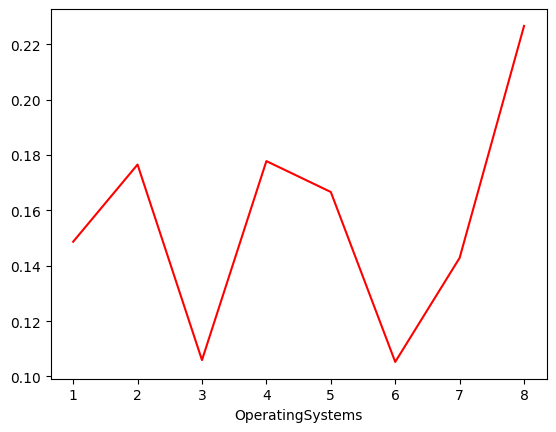

In [12]:
# @title Average Visitors by Operating Systems

df.groupby('OperatingSystems')['Revenue'].mean().plot(kind='line', color='red')

Here we can observe the pattern of visitor preference according to their Operating System.

**Conclusion**: Users using `Operating System 8` have the **highest** likelihood of making a purchase, while users using `Operating System 3 and 6` have a **lower** propensity to make a purchase.

### EDA - Bi-Variate Analysis

#### Correlational Matrix

A correlation matrix measures the magnitude and direction of the linear association between pairs of variables.

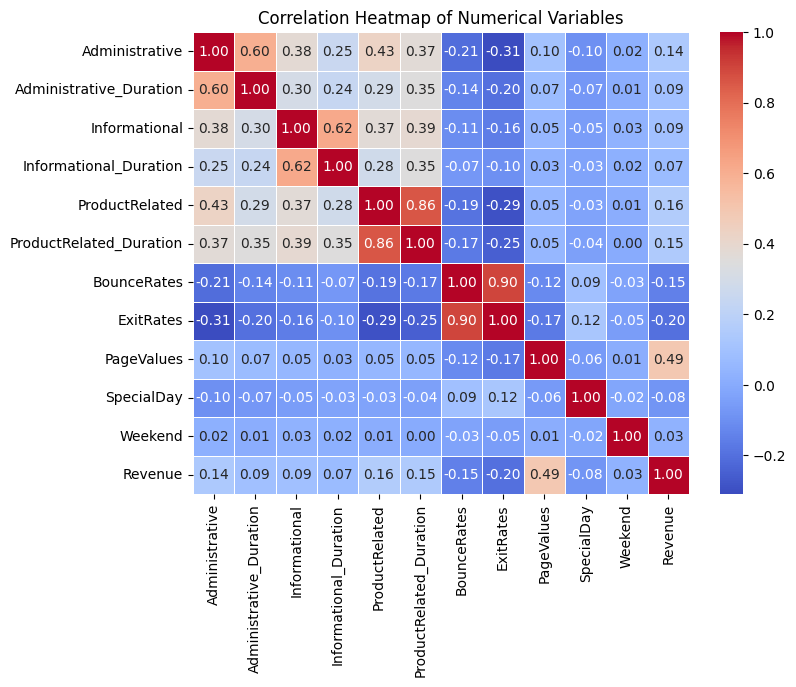

In [13]:
numerical_features_with_target = numerical_features + ['Revenue']
# Compute the correlation matrix
corr = df[numerical_features_with_target].corr().round(2)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

**Conclusion**: Our matrix assesses these relationships by selecting variables that demonstrate a substantial correlation with the 'Revenue' attribute, which indicates prediction but not causation. The matrix reveals that the correlation coefficients between the 'Revenue' attribute and other aspects are `comparatively low`, suggesting the existence of complex, potentially non-linear relationships between the label and the features.

#### Revenue Distribution by Month

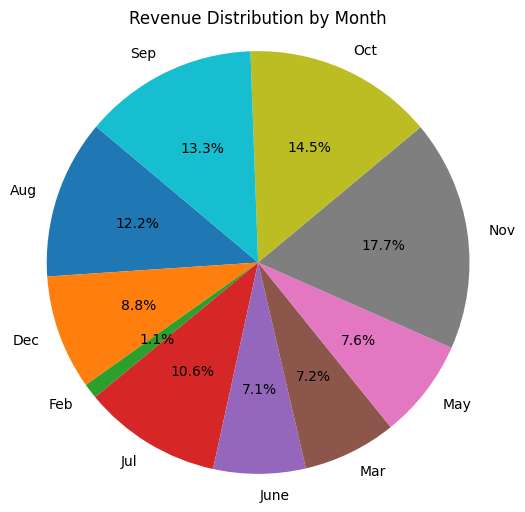

In [14]:
# Calculate the total revenue for each month
revenue_by_month = df.groupby('Month')['Revenue'].mean()

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(revenue_by_month, labels=revenue_by_month.index, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Month')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Conclusion**: The pie chart clearly indicates that the months of `August`, `September`, `October`, and `November` have a **higher likelihood** of user purchases compared to other months.


---



#### Categorical Features vs. Revenue

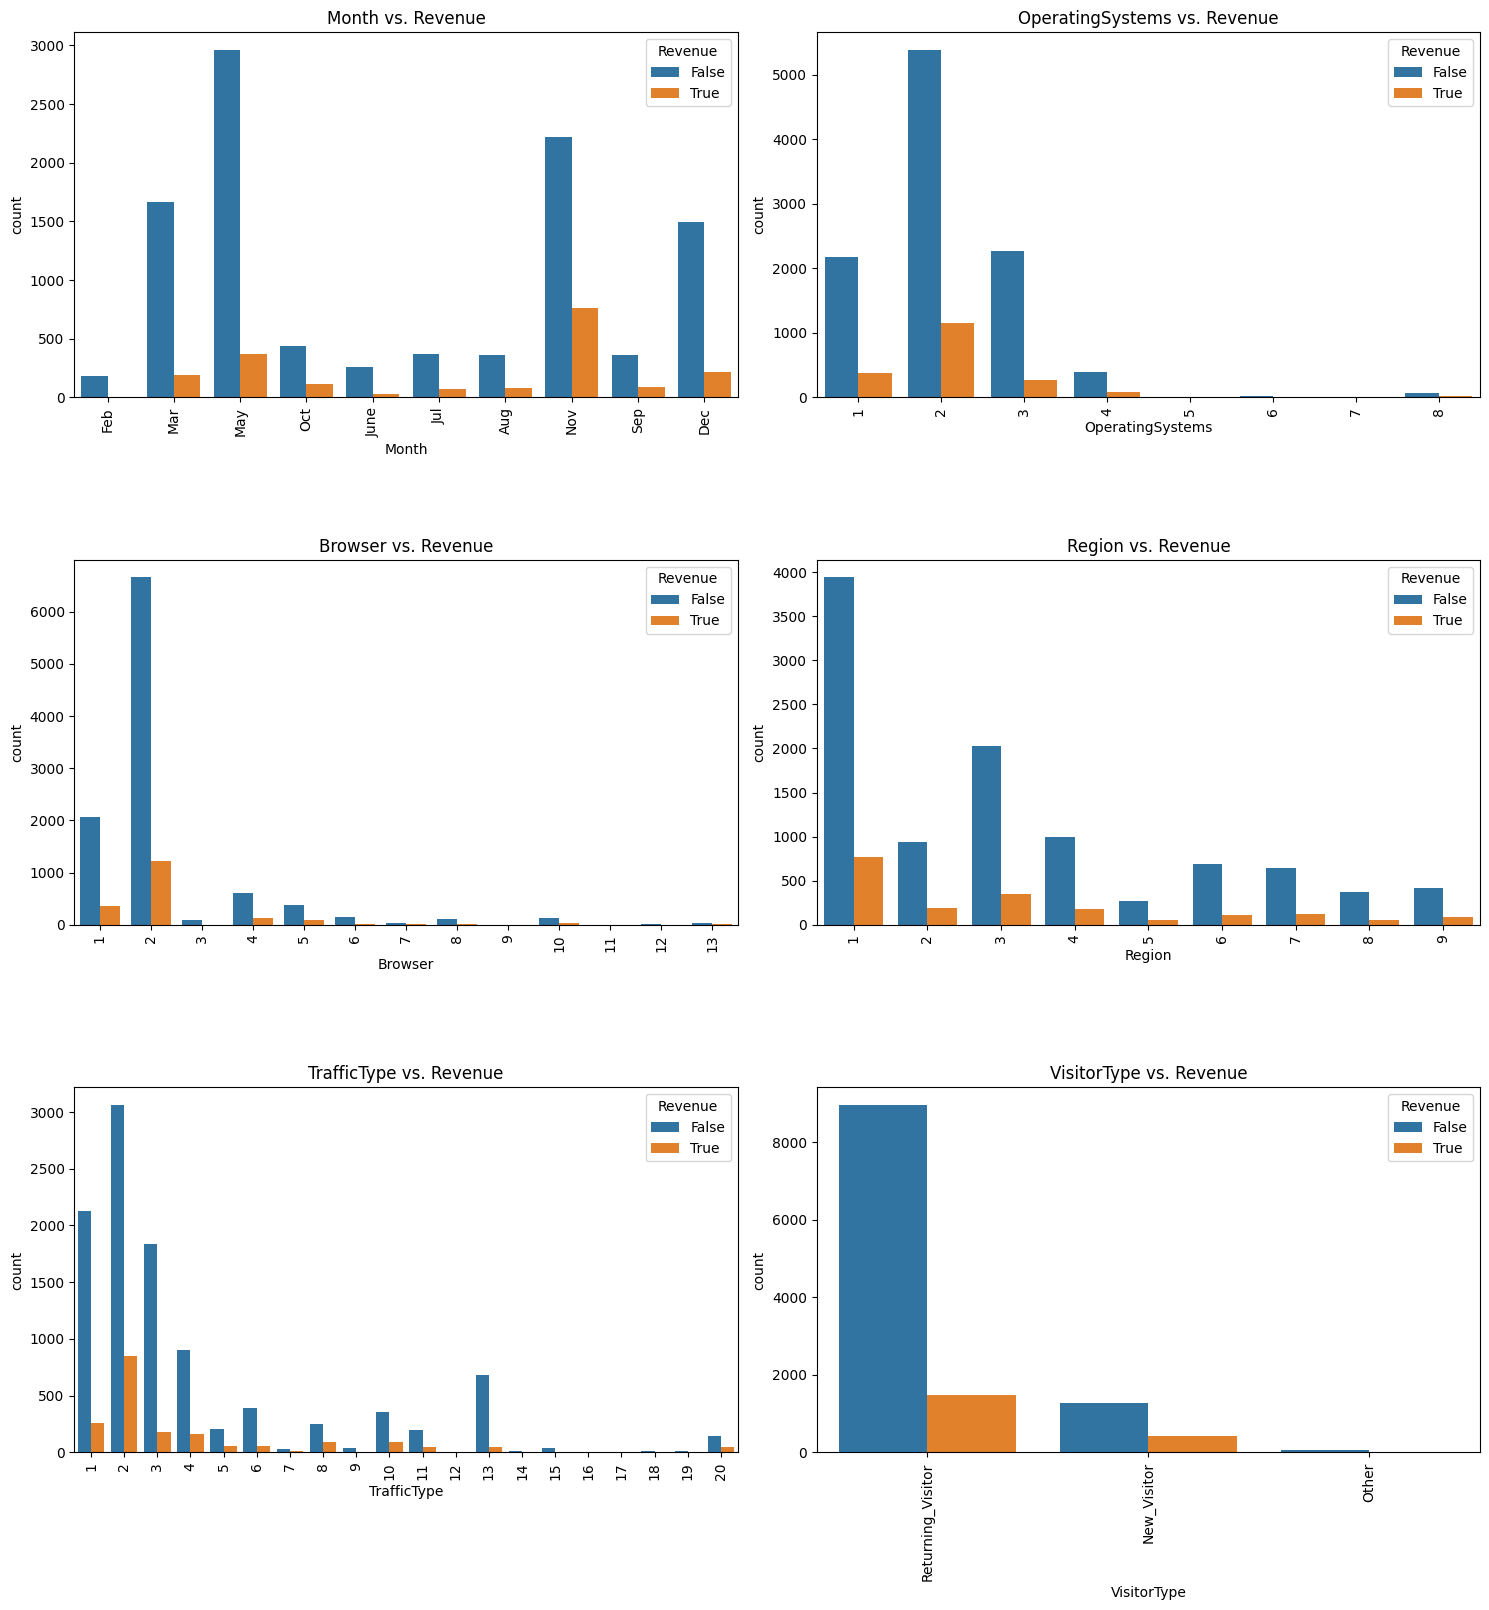

In [15]:
# Bivariate Analysis - Categorical Features vs. Revenue
plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=feature, hue='Revenue')
    plt.title(f'{feature} vs. Revenue')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### **Month vs. Revenue:**

- Revenue is higher in March, May, and November, with significant counts of sessions leading to revenue (orange bars).
- February and December have relatively low counts of sessions, with even fewer resulting in revenue.
- Most other months show a low conversion to revenue.

#### **Operating Systems vs. Revenue:**

- The majority of sessions occur on Operating Systems 1 and 2.
- Both OS 1 and OS 2 have higher counts of sessions that result in revenue compared to other operating systems.
- Other operating systems (3, 4, 5, 6, 7, 8) show very low counts and minimal revenue generation.

#### **Browser vs. Revenue:**

- Browsers 1 and 2 dominate in terms of session counts.
- Both also show a higher number of sessions leading to revenue.
- Other browsers (3 through 13) have significantly lower counts, with minimal sessions generating revenue.

#### **Region vs. Revenue:**

- Regions 1 and 3 have the highest session counts, with a notable portion leading to revenue.
- Region 2 also shows a relatively higher count with some revenue generation.
- Other regions (4 through 9) have fewer sessions and correspondingly lower revenue outcomes.

#### **TrafficType vs. Revenue:**

- Traffic types 2 and 1 have the highest session counts, with a significant portion converting to revenue.
- Traffic types 3 and 4 also show a moderate count with some revenue generation.
- The remaining traffic types (5 through 20) have lower session counts and minimal revenue generation.

#### **VisitorType vs. Revenue:**

- Returning visitors have the highest session counts and generate more revenue.
- New visitors also contribute to revenue but at a much lower rate compared to returning visitors.
- 'Other' visitor type has very few sessions and minimal revenue.



---



#### **General Conclusions:**

- High-Performing Months: March, May, and November are strong months for revenue generation.
- Dominant OS and Browsers: Sessions on Operating Systems 1 and 2, and Browsers 1 and 2, are more likely to generate revenue.
- Region Performance: Regions 1 and 3 are the top performers in terms of session counts and revenue generation.
- Effective Traffic Types: Traffic types 1 and 2 are more effective in driving sessions and converting them to revenue.


## Missing Value Treatment

In [16]:
# Handling missing values for numerical features
for feature in numerical_features:
    df[feature].fillna(df[feature].median(), inplace=True)  # Using median to fill missing values

# Handling missing values for categorical features
for feature in categorical_features:
    df[feature].fillna(df[feature].mode()[0], inplace=True)  # Using mode to fill missing values

# Verify that there are no missing values left
print("\nMissing Values after Treatment:")
print(df.isnull().sum())


Missing Values after Treatment:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


**Imputes missing values**: Replaces missing numerical values with the `median` and missing categorical values with the `mode`.

**Verifies**: Checks for any remaining missing values after imputation.

## Outlier Detection & Removal

**Outlier Handling Function**

In this section, we define a function called `handle_outliers` to manage outliers in our dataset. Outliers are data points that differ significantly from other observations and can skew our analysis, leading to inaccurate predictions.

This function accepts the following parameters:
- `df`: The DataFrame containing our dataset.
- `numerical_features`: A list of column names representing numerical features where we suspect outliers might exist.
- `method`: The method for handling outliers. It can be one of three options:
    - 'remove': Completely removes the outliers from the dataset.
    - 'cap': Caps the outlier values to a threshold based on the mean and standard deviation.
    - 'transform': Applies a transformation, such as the Box-Cox transformation, to reduce the impact of outliers.
- `threshold`: The Z-score threshold to define outliers. Typically, a Z-score above 3 is considered an outlier, but this can be adjusted.

**Why Handling Outliers is Important**

Outliers can distort the training process of our models, especially in sensitive models like Artificial Neural Networks (ANN). By carefully handling outliers, we ensure that our model remains robust and generalizes well to new data.


**How the Function Works**
1. **Z-score Calculation**: We start by calculating the Z-score for each numerical feature to identify potential outliers.
2. **Outlier Handling**:
   - If the method is 'remove', the function drops rows containing outliers.
   - If the method is 'cap', the function caps the outlier values to a certain threshold.
   - If the method is 'transform', the function applies a Box-Cox transformation to normalize the data and reduce the impact of outliers.

After processing, the function returns the cleaned DataFrame, ready for further analysis or model training.


---



In [17]:
def handle_outliers(df, numerical_features, method, threshold):
    """
    Handle outliers in the dataset.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        numerical_features (list): List of numerical feature column names.
        method (str): Method for handling outliers ('remove', 'cap', or 'transform').
        threshold (float): Z-score threshold for defining outliers.

    Returns:
        pd.DataFrame: Dataframe after handling outliers.
    """
    # Ensure numerical features are numeric
    df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(df[numerical_features], nan_policy='omit'))
    outliers = (z_scores > threshold)

    num_outliers = np.sum(outliers.any(axis=1))
    print(f"Number of identified outliers: {num_outliers}")

    if method == 'remove':
        # Option 1: Remove outliers
        df_clean = df[~(outliers.any(axis=1))]
        print(f"Removed {num_outliers} outliers. Original shape: {df.shape}, New shape: {df_clean.shape}")
        return df_clean

    elif method == 'cap':
        # Option 2: Cap outliers
        df_capped = df.copy()
        for feature in numerical_features:
            mean = df[feature].mean()
            std = df[feature].std()
            cap_value = mean + threshold * std
            df_capped[feature] = np.where(df_capped[feature] > cap_value, cap_value, df_capped[feature])
        print(f"Capped values for {num_outliers} outliers. Shape remains unchanged: {df_capped.shape}")
        return df_capped

    elif method == 'transform':
        # Option 3: Transform outliers (e.g., Box-Cox transformation)
        df_transformed = df.copy()
        for feature in numerical_features:
            # Handle non-positive values for Box-Cox transformation
            positive_values = df_transformed[feature] + 1 - df_transformed[feature].min()
            transformed_values, _ = boxcox(positive_values[positive_values > 0])
            # Fill transformed values back, using original column index positions
            df_transformed.loc[positive_values.index, feature] = transformed_values
        print(f"Transformed values for {num_outliers} outliers. Shape remains unchanged: {df_transformed.shape}")
        return df_transformed

    else:
        raise ValueError("Method must be one of 'remove', 'cap', or 'transform'.")


In [18]:
df = handle_outliers(df, numerical_features, method='transform', threshold=5)

Number of identified outliers: 431
Transformed values for 431 outliers. Shape remains unchanged: (12205, 18)


## Feature Engineering

### Feature Encoding

**Applying cyclical encoding to represent the Month feature**


> We implemented cycle encoding to account for the cyclical pattern of months in the 'Month' function.



The recurrent pattern of months makes traditional numerical encoding insufficient for accurately representing their relationship. In order to tackle this issue, we employed `sine and cosine transformations` to assign each month a specific location on a circle, so accurately representing the cyclical nature of the months. Utilizing this technique is crucial in modelling e-commerce data, since **it enables algorithms to identify and exploit seasonal patterns in online shopping behaviors.**



In [19]:
def encode_month(df, month_column='Month'):
    """
    Encode the month column using sine and cosine transformation.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        month_column (str): The column name containing month data.

    Returns:
        pd.DataFrame: Dataframe with encoded month values and original month column removed.
    """
    # Assign a numerical value to each month
    month_to_num = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5,
        'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9,
        'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # Map month names to numerical values
    df['month_num'] = df[month_column].map(month_to_num)

    # Encode with sine and cosine
    df['month_sin'] = np.sin((df['month_num'] - 1) * (2. * np.pi / 12))
    df['month_cos'] = np.cos((df['month_num'] - 1) * (2. * np.pi / 12))

    # Drop the original month column and the temporary numerical column
    df.drop(columns=[month_column, 'month_num'], inplace=True)

    print("Encoding for Month variable completed...")
    return df

df = encode_month(df, month_column='Month')


Encoding for Month variable completed...


#### **Encoding VisitorType feature**

In [20]:
# Function to one-hot encode 'VisitorType'
def one_hot_encode_visitor_type(df, column_name='VisitorType'):
    # Create one-hot encoded columns
    visitor_types = df[column_name].unique()
    for visitor_type in visitor_types:
        df[f'{column_name}_{visitor_type}'] = (df[column_name] == visitor_type).astype(int)

    # Drop the original 'VisitorType' column
    df.drop(columns=[column_name], inplace=True)
    print("One Hot Encoding completed for variable VisitorType...")
    return df

# Apply the one-hot encoding function
df = one_hot_encode_visitor_type(df)

One Hot Encoding completed for variable VisitorType...


#### **Encoding all the others categorical features with OneHotEncoding**
The dataset had multiple category variables, including `'OperatingSystems'`, `'Browser', 'Region', 'VisitorType'`, and `'TrafficType'`. In order to ensure compatibility between these features and our models, we used One-Hot encoding. This method involves creating a new binary column for every level of categories found in the original feature.



> This method guarantees that the models can handle these category features without making any assumptions about their ordinal connection.



In [21]:
def one_hot_encode(df):
    """
    One-hot encode all categorical columns in the dataframe.

    Parameters:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: Dataframe with one-hot encoded columns and original categorical columns removed.
    """
    encoder = OneHotEncoder(sparse_output=False)

    # Iterate through all categorical columns
    for col in df.select_dtypes(include='object'):
        # Fit and transform the column
        transformed = encoder.fit_transform(df[[col]])

        # Create a DataFrame from the encoded columns
        encoded_df = pd.DataFrame(transformed, columns=[f"{col}_{category}" for category in encoder.categories_[0]])

        # Add the new columns to the original DataFrame
        df = df.join(encoded_df.set_index(df.index))

    # Drop the original categorical columns
    df.drop(columns=df.select_dtypes(include='object').columns, inplace=True)

    print("One-hot encoding of remaining Categorical variables completed...")

    return df


df = one_hot_encode(df)


One-hot encoding of remaining Categorical variables completed...


### Feature Importance


**Feature Importance Calculation**

This function calculates the importance of each feature in predicting the target variable using a RandomForestClassifier.

**Parameters:**
- `df`: The DataFrame containing both features and the target variable.
- `target_column`: The name of the target column in the DataFrame.

**How it Works:**
1. **Feature and Target Separation**: The dataset is split into features (`X`) and the target variable (`y`).
2. **RandomForestClassifier**: A Random Forest model is initialized and trained on the data. Random Forest is an ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.
3. **Feature Importance**: After fitting the model, the importance of each feature is determined based on how much it contributes to reducing the impurity in the data. This importance is then sorted and returned in a DataFrame.

**Importance and Impact**

Understanding feature importance is crucial for interpreting the model's behavior. It helps us identify which features contribute most to predicting the target, allowing for better feature selection and model tuning.



> By focusing on the most important features, we can improve model performance, reduce overfitting, and make our model more interpretable.





In [22]:
def calculate_feature_importance(df, target_column):
    """
    Calculate feature importance using RandomForestClassifier.

    Parameters:
        df (pd.DataFrame): Input dataframe containing features and target.
        target_column (str): The name of the target variable column.

    Returns:
        feature_importances (pd.DataFrame): DataFrame with feature names and their importance scores.
    """
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Initialize RandomForestClassifier
    model = RandomForestClassifier(random_state=42)

    # Fit the model
    model.fit(X, y)

    # Get feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    print(f"Feature importance calculated for {len(X.columns)} features.")

    return feature_importances

In [23]:
# First, calculate the feature importance
feature_importances = calculate_feature_importance(df, target_column='Revenue')

Feature importance calculated for 66 features.


### Feature Selection


**Feature Selection and Visualization**

This function selects the top percentage of features based on their importance scores and visualizes the top 10 most important features.

**Parameters:**
- `df`: The DataFrame containing all features and the target variable.
- `feature_importances`: A DataFrame with feature names and their importance scores, calculated earlier.
- `target_column`: The name of the target column in the DataFrame.
- `top_percentage`: The percentage of top features to retain, defaulting to 80%.

**How it Works:**
1. **Feature Selection**: The function first determines how many features to keep based on the specified `top_percentage`. For example, if `top_percentage=0.8`, the top 80% of features are selected.
2. **DataFrame Creation**: A new DataFrame is created containing only the selected top features along with the target column.
3. **Visualization**: The top 10 features are visualized using a bar plot, giving a clear view of the most influential features in predicting the target variable.

**Importance and Impact**

Selecting the most important features helps in reducing the dimensionality of the dataset, leading to faster training times and potentially better model performance. By focusing on the top features, we can streamline the model, making it less prone to overfitting and more interpretable. Additionally, visualizing the top 10 features offers insights into which aspects of the data are most critical for predicting outcomes, guiding further analysis and feature engineering.



In [24]:
def select_top_features(df, feature_importances, target_column, top_percentage=0.8):
    """
    Select the top percentage of features based on importance and plot the top 10 features.

    Parameters:
        df (pd.DataFrame): Input dataframe containing features and target.
        feature_importances (pd.DataFrame): DataFrame with feature names and their importance scores.
        target_column (str): The name of the target variable column.
        top_percentage (float): Percentage of features to select based on importance.

    Returns:
        df_selected (pd.DataFrame): DataFrame with top selected features and target column.
    """
    # Determine the number of features to select
    num_features_to_select = int(top_percentage * len(feature_importances))

    # Select the top features based on importance
    selected_features = feature_importances['Feature'].head(num_features_to_select).tolist()

    # Create new DataFrame with selected features and the target column
    df_selected = df[selected_features + [target_column]]

    print(f"Selected top {top_percentage*100}% features, retaining {len(selected_features)} out of {len(feature_importances)} features.")

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
    plt.title('Top 10 Important Features')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.show()

    return df_selected

Selected top 80.0% features, retaining 52 out of 66 features.


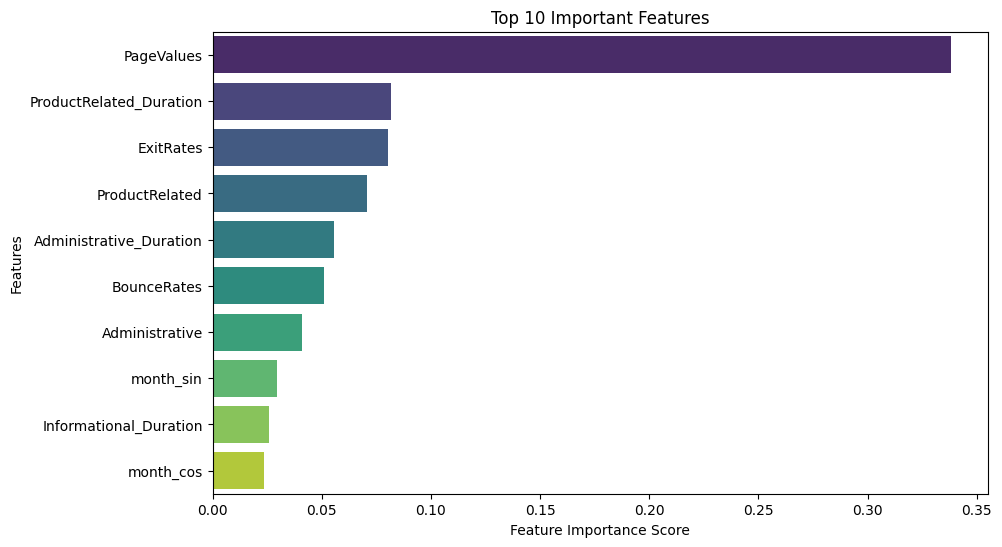

In [25]:
# Now, select the top 80% features and plot the top 10
df = select_top_features(df, feature_importances, target_column='Revenue')

In [26]:
df.shape

(12205, 53)

### Feature Scaling


**Scaling Numerical Features**

This function standardizes all `numerical features` in the dataset while excluding the target variable from scaling. Standardization is crucial because it ensures that each feature contributes equally to the model, preventing features with larger ranges from dominating the learning process.




> By scaling the features, we enhance the performance of models like neural networks, which are sensitive to feature magnitudes. This step prepares the data for more effective and balanced training, helping to improve model accuracy.




In [27]:
def scale_numerical_features_exclude_target(df, target_column):
    """
    Scale all numerical columns in the dataframe except for the target variable.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column to exclude from scaling.

    Returns:
        pd.DataFrame: Dataframe with scaled numerical columns, excluding the target variable.
    """
    scaler = StandardScaler()

    # Select numerical columns excluding the target column
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols[numerical_cols != target_column]

    # Scale numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df


df = scale_numerical_features_exclude_target(df, target_column='Revenue')


## Data Oversampling - SMOTE

This function addresses class imbalance in the dataset using the SMOTE (Synthetic Minority Over-sampling Technique) method. Class imbalance can lead to **biased models** that perform poorly on the minority class. SMOTE helps by generating synthetic examples for the minority class, balancing the dataset.

By applying SMOTE, we create a more balanced dataset, improving the model's ability to learn from all classes and reducing the risk of biased predictions. This step is crucial for models like neural networks, which benefit from balanced training data.



In [28]:
def oversample_with_smote(df, target_column):
    """
    Perform data oversampling using the SMOTE technique.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: Dataframe with oversampled data.
        pd.Series: Series with oversampled target values.
    """
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Initialize SMOTE
    smote = SMOTE(random_state=42)

    # Fit and transform the data
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new dataframe from the resampled data
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled, y_resampled

# Example usage
df_resampled, y_resampled = oversample_with_smote(df, target_column='Revenue')


In [29]:
df_resampled.shape

(20594, 53)

In [30]:
# Check the balance of the target variable 'Revenue'
print("\nDistribution of the target variable 'Revenue' in df_resampled:")
print(df_resampled['Revenue'].value_counts(normalize=True))


Distribution of the target variable 'Revenue' in df_resampled:
Revenue
False    0.5
True     0.5
Name: proportion, dtype: float64


## Train Test Split

In [31]:
def split_data(df, target_column, test_size=0.2, random_state=42):
    """
    Split the original dataframe into training and testing sets.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed used by the random number generator.

    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
    """
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test



In [32]:
# Separate features and target variable
X = df.drop(columns=['Revenue'])
y = df['Revenue']

# Perform train-test split
X_train, X_test, y_train, y_test = split_data(df, target_column='Revenue')


## Supporting Plot Functions

Supporting functions are created to ensure we can reuse this code in each of the algorithm to generate the required plots for better understanding of the model with respect to performance

The tables/plots includes -


1.   Metric Table which includes - `Accuracy, AUC-ROC and Recall`
2.   Confusion matrix
3.   ROC Curve
4.   Validation loss Curve



In [33]:
# Function to print metrics in a table-like format
def print_metrics_table(metrics):
    """
    Print the metrics for each model in a table-like format.

    Parameters:
        metrics (dict): Dictionary with model names as keys and evaluation metrics as values.
    """
    print(f"{'Model':<20} {'Accuracy':<10} {'AUC-ROC':<10} {'Recall':<10}")
    print("="*50)
    for model_name, scores in metrics.items():
        print(f"{model_name:<20} {scores['Accuracy']:<10.4f} {scores['AUC-ROC']:<10.4f} {scores['Recall']:<10.4f}")

In [34]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of class labels.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [35]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot the ROC curve.

    Parameters:
        y_true (array-like): True binary labels.
        y_pred_proba (array-like): Predicted probabilities.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


In [36]:
def plot_validation_loss(history):
    """
    Plot the validation loss from training history.

    Parameters:
        history (keras.callbacks.History): Training history object from Keras.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.show()


In [37]:
# Define the columns
columns = ['Model', 'Accuracy', 'AUC-ROC', 'Recall']

# Create an empty DataFrame with these columns
eval_results_df = pd.DataFrame(columns=columns)

## Classical ML Models


**Evaluating Classical Machine Learning Models**

The code below trains and evaluates several classical machine learning models, including `Logistic Regression`, `Support Vector Machine (SVM)`, and `Decision Tree`, on the purchase prediction dataset. Each model is assessed using key performance metrics: `accuracy`, `AUC-ROC`, and `recall`.


> By comparing these models, we can identify which algorithm performs best for our specific problem. This helps in selecting a robust model before moving on to more complex approaches like deep learning.






In [38]:
def evaluate_classical_ml_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate classical ML models on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with model names as keys and evaluation metrics (accuracy, AUC-ROC, recall) as values.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    metrics = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)

        # Store metrics
        metrics[model_name] = {
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Recall': recall
        }

    return metrics



In [39]:
# usage with normal data
metrics_normal = evaluate_classical_ml_models(X_train, X_test, y_train, y_test)
print("Metrics for Normal Data:")
print_metrics_table(metrics_normal)


Metrics for Normal Data:
Model                Accuracy   AUC-ROC    Recall    
Logistic Regression  0.8902     0.9034     0.5691    
SVM                  0.8898     0.8753     0.5276    
Decision Tree        0.8640     0.7342     0.5497    


In [40]:
# Dictionary containing the metrics
metrics_dict = metrics_normal

# Create a list of models
models = ['Logistic Regression', 'SVM', 'Decision Tree']

# List to hold the new rows
new_rows = []

# Collect data rows
for model in models:
    metrics = metrics_dict[model]
    new_rows.append({'Model': model,
                     'Accuracy': metrics['Accuracy'],
                     'AUC-ROC': metrics['AUC-ROC'],
                     'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)

# eval_results_df.head()


### Ensemble ML Models


Evaluating Ensemble Machine Learning Models

This function trains and evaluates ensemble models, specifically `Random Forest` and `XGBoost` on the dataset. These models combine the strengths of multiple decision trees to improve predictive performance.

By leveraging ensemble methods, we aim to enhance model stability and accuracy, making them powerful choices for complex datasets.



In [41]:
def evaluate_ensemble_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate ensemble ML models (Random Forest and XGBoost) on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with model names as keys and evaluation metrics (accuracy, AUC-ROC, recall) as values.
    """
    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    metrics = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)

        # Store metrics
        metrics[model_name] = {
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Recall': recall
        }

    return metrics


In [42]:
# Example usage with normal data
metrics_normal_ensemble = evaluate_ensemble_models(X_train, X_test, y_train, y_test)
print("Metrics for Normal Data (Ensemble Models):")
print_metrics_table(metrics_normal_ensemble)


Metrics for Normal Data (Ensemble Models):
Model                Accuracy   AUC-ROC    Recall    
Random Forest        0.9045     0.9235     0.5442    
XGBoost              0.8980     0.9201     0.5691    


**Conclusion**:

The evaluation of classical and ensemble machine learning models reveals that ensemble models, particularly **Random Forest** and **XGBoost**, offer better performance compared to classical models in terms of accuracy, AUC-ROC, and recall. Notably, XGBoost achieved the highest recall score among all models.

**Impact and Importance:**

Prioritizing recall is essential for this project as we aim to **minimize false negatives**. High recall ensures that potential buyers are not missed, allowing for timely notifications and targeted marketing efforts.



> `This approach is crucial for maximizing conversion rates and optimizing customer engagement strategies. By focusing on models with higher recall, we can effectively enhance our ability to retain and upsell to potential customers, ultimately driving better business outcomes.`



In [43]:
# Dictionary containing the metrics
metrics_dict = metrics_normal_ensemble

# Create a list of models
models = ['Random Forest', 'XGBoost']

# List to hold the new rows
new_rows = []

# Collect data rows
for model in models:
    metrics = metrics_dict[model]
    new_rows.append({'Model': model,
                     'Accuracy': metrics['Accuracy'],
                     'AUC-ROC': metrics['AUC-ROC'],
                     'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)

# eval_results_df.head()


## Baseline Neural Network

In [44]:
def evaluate_neural_network(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a simple baseline neural network on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with evaluation metrics (accuracy, AUC-ROC, recall) for the neural network.
    """
    # Define the neural network model
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    plot_validation_loss(history)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


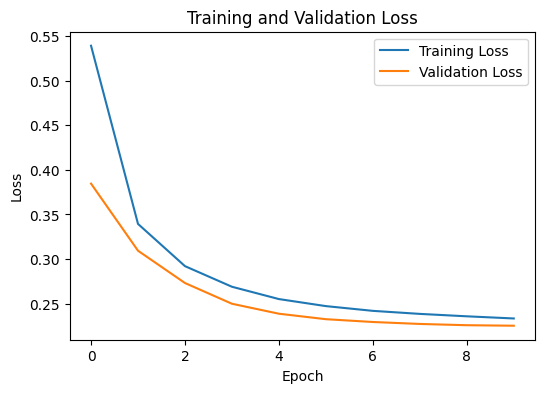

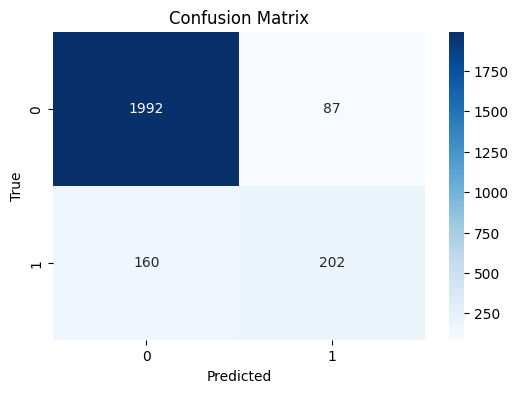

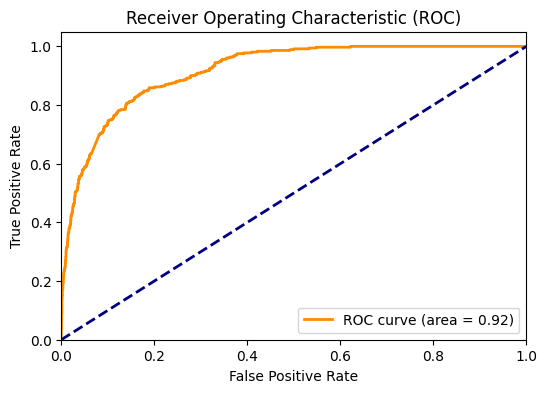


Metrics for Normal Data (Baseline Neural Network):
Model                Accuracy   AUC-ROC    Recall    
Baseline Neural Network 0.8988     0.9162     0.5580    




In [45]:
# Example usage with normal data
metrics_normal_nn = evaluate_neural_network(X_train, X_test, y_train, y_test)
print("\nMetrics for Normal Data (Baseline Neural Network):")
print_metrics_table({'Baseline Neural Network': metrics_normal_nn})
print("\n")

**Impact and Importance of Baseline Neural Network:**

The baseline neural network demonstrates strong performance with a **high AUC-ROC score**, indicating good model discrimination between classes. The recall score, though lower compared to ensemble models like XGBoost, still highlights the model's ability to identify potential buyers.

Focusing on recall is critical for minimizing false negatives and ensuring potential buyers are not missed.



> The neural network provides a solid foundation and may be enhanced further with advanced architectures or hyperparameter tuning to improve recall and overall performance.



In [46]:
# Dictionary containing the metrics
metrics_dict = metrics_normal_nn

# Create a list of models
model = 'Baseline Neural Network'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


## LSTM RNN

In [47]:
def prepare_data_for_lstm(X, y, timesteps=1):
    """
    Reshape data for LSTM input.

    Parameters:
        X (pd.DataFrame): Features.
        y (pd.Series): Target values.
        timesteps (int): Number of timesteps.

    Returns:
        X_lstm (np.array): Reshaped features.
        y (np.array): Target values.
    """
    X = X.values
    y = y.values

    # Reshape data to 3D array (samples, timesteps, features)
    X_lstm = np.reshape(X, (X.shape[0], timesteps, X.shape[1]))

    return X_lstm, y


In [48]:
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: A compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [49]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    """
    Train and evaluate the LSTM model.

    Parameters:
        X_train (np.array): Training features.
        y_train (np.array): Training target values.
        X_test (np.array): Testing features.
        y_test (np.array): Testing target values.
        epochs (int): Number of epochs.
        batch_size (int): Batch size.

    Returns:
        dict: Evaluation metrics (accuracy, AUC-ROC, recall).
        str: Summary of the LSTM model architecture.
    """
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0
    )

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Capture model summary
    buffer = io.StringIO()
    model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    return metrics, model_summary, history, model


In [50]:
def print_nn_training_summary_lstm(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for LSTM Neural Network:")
    print_metrics_table({'LSTM Neural Network': metrics})

    # Print model architecture summary
    print("\nLSTM Neural Network Architecture Summary:")
    print(model_summary)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Metrics and Architecture Summary for LSTM Model:
Metrics for LSTM Neural Network:
Model                Accuracy   AUC-ROC    Recall    
LSTM Neural Network  0.8853     0.8947     0.5525    

LSTM Neural Network Architecture Summary:
Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          20,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├────────────────────────────────

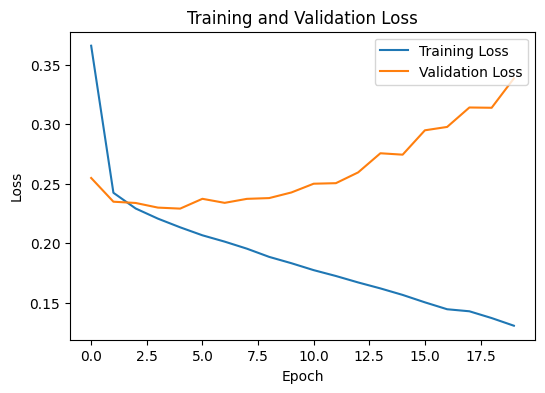

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


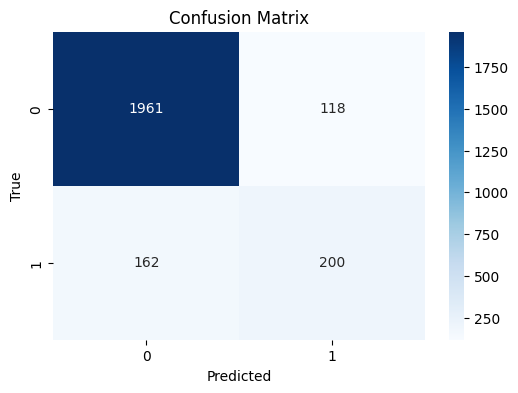

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


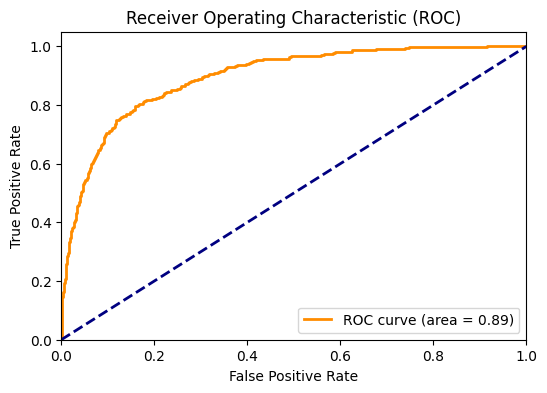

In [51]:
# Example usage for normal data
X_train_lstm, y_train_lstm = prepare_data_for_lstm(X_train, y_train, timesteps=1)
X_test_lstm, y_test_lstm = prepare_data_for_lstm(X_test, y_test, timesteps=1)

metrics_lstm, model_summary_lstm, history_lstm, model_lstm = train_and_evaluate_lstm(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

print("Metrics and Architecture Summary for LSTM Model:")
print_nn_training_summary_lstm(metrics_lstm, model_summary_lstm)
plot_validation_loss(history_lstm)
plot_confusion_matrix(y_test_lstm, (model_lstm.predict(X_test_lstm) > 0.5).astype(int), labels=[0, 1])
plot_roc_curve(y_test_lstm, model_lstm.predict(X_test_lstm).ravel())


**Explanation:**

The code defines and evaluates an LSTM (Long Short-Term Memory) neural network for sequential data. The `build_lstm_model` function constructs an LSTM model with two LSTM layers and a dropout layer to prevent overfitting. The model is compiled using the Adam optimizer and binary cross-entropy loss.

The `train_and_evaluate_lstm` function trains the LSTM model on the training data and evaluates it on the test data. It calculates key metrics such as accuracy, AUC-ROC, and recall. The function also captures the model summary, which details the architecture of the LSTM network.

**Conclusion:**

When compared to the baseline neural network model:

- The LSTM model shows a slightly lower accuracy but improves recall, `indicating a better ability to identify potential buyers`.
- The AUC-ROC score of the LSTM model is also slightly lower , suggesting that while the LSTM performs well in recall, its overall discrimination capability is slightly less.



> The improved recall with the LSTM model is significant for minimizing false negatives, which is crucial for identifying potential buyers. This makes the LSTM model a valuable addition, enhancing our ability to engage with potential customers effectively.




In [52]:
# Dictionary containing the metrics
metrics_dict = metrics_lstm

# Create a list of models
model = 'LSTM RNN Model'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


### Hyperparameter Tuning of ANN

In [53]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [54]:
import keras_tuner as kt

def build_hypermodel(hp, input_shape):
    """
    Build a hypermodel for Keras Tuner with tunable hyperparameters.

    Parameters:
        hp (kt.HyperParameters): Hyperparameters object.
        input_shape (int): Number of features in the input data.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    # Tunable number of neurons and layers
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', min_value=1e-4, max_value=1e-2, sampling='log'))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.3, max_value=0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def tune_hyperparameters(X_train, y_train, n_trials=10):
    """
    Tune hyperparameters using Keras Tuner.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target values.
        n_trials (int): Number of trials for hyperparameter tuning.

    Returns:
        kt.HyperBand: Keras Tuner object.
        dict: Best hyperparameters found.
    """
    def hypermodel_builder(hp):
        return build_hypermodel(hp, X_train.shape[1])

    tuner = kt.Hyperband(
        hypermodel_builder,
        objective='val_accuracy',
        max_epochs=10,
        hyperband_iterations=2,
        directory='my_dir',
        project_name='my_project',
        overwrite=True
    )

    tuner.search(
        X_train, y_train,
        epochs=10,
        validation_split=0.1,
        batch_size=32
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters found:")
    for key, value in best_hps.values.items():
        print(f"{key}: {value}")

    return tuner, best_hps

def evaluate_model_with_best_hps(X_train, X_test, y_train, y_test, tuner):
    """
    Evaluate the model with the best hyperparameters on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        tuner (kt.HyperBand): Keras Tuner object.

    Returns:
        dict: Evaluation metrics (accuracy, AUC-ROC, recall).
        str: Summary of the neural network architecture.
    """
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the model with the best hyperparameters
    history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

    # Predict on test set
    y_pred_proba = best_model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Capture model summary
    buffer = io.StringIO()
    best_model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    # plot_validation_loss(history)
    # plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics, model_summary

def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Advanced Neural Network with Hyperparameter Tuning:")
    print_metrics_table({'Advanced Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)



Trial 60 Complete [00h 00m 15s]
val_accuracy: 0.9027635455131531

Best val_accuracy So Far: 0.9027635455131531
Total elapsed time: 00h 12m 09s
Best hyperparameters found:
num_layers: 3
units_0: 32
l2_0: 0.0028168240891253142
dropout_0: 0.3
units_1: 128
l2_1: 0.001858634561395444
dropout_1: 0.5
learning_rate: 0.003732448879534993
units_2: 96
l2_2: 0.0008170324354132605
dropout_2: 0.3
units_3: 64
l2_3: 0.0004015468154912499
dropout_3: 0.4
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


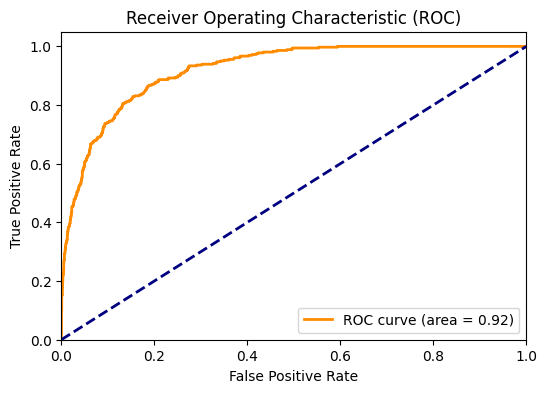


Metrics and Architecture Summary for Normal Data (Advanced Neural Network with Hyperparameter Tuning):
Metrics for Advanced Neural Network with Hyperparameter Tuning:
Model                Accuracy   AUC-ROC    Recall    
Advanced Neural Network 0.8964     0.9198     0.6133    

Neural Network Architecture Summary:
Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │           1,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │

In [55]:
# Example usage with normal data
tuner, best_hps = tune_hyperparameters(X_train, y_train, n_trials = 5)
metrics_normal_nn, model_summary_normal_nn = evaluate_model_with_best_hps(X_train, X_test, y_train, y_test, tuner)
print("\nMetrics and Architecture Summary for Normal Data (Advanced Neural Network with Hyperparameter Tuning):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)


**Summary:**

The code implements an advanced neural network with hyperparameter tuning using Keras Tuner. It builds and optimizes a neural network model by adjusting parameters such as the number of layers, units per layer, dropout rates, and regularization techniques. The model is then evaluated based on key performance metrics: `accuracy`, `AUC-ROC`, and `recall`.

**Importance:**

Hyperparameter tuning is crucial for improving the performance of machine learning models. By optimizing these parameters, the neural network becomes better suited to the specific data characteristics, which can lead to enhanced performance in identifying potential buyers.


In [56]:
# Dictionary containing the metrics
metrics_dict = metrics_normal_nn

# Create a list of models
model = 'Hyperparameter Tuned ANN'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


### Train Test Split - Oversampled Data using SMOTE

In [57]:
def split_resampled_data(df_resampled, target_column, test_size=0.2, random_state=42):
    """
    Split the resampled dataframe into training and testing sets.

    Parameters:
        df_resampled (pd.DataFrame): The resampled dataframe.
        target_column (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed used by the random number generator.

    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
    """
    # Separate features and target variable
    X = df_resampled.drop(columns=[target_column])
    y = df_resampled[target_column]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [58]:
# Separate features and target variable
X_r = df_resampled.drop(columns=['Revenue'])
y_r = df_resampled['Revenue']

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = split_resampled_data(df_resampled, target_column='Revenue')

## Enhanced Neural Network - with Cross Validation Technique


The `evaluate_advanced_neural_network` function performs K-Fold cross-validation to evaluate an advanced neural network model. It splits the data into multiple folds, trains and tests the model on each fold, and computes key evaluation metrics (accuracy, AUC-ROC, and recall) for each fold. The function also captures and returns the model architecture summary and provides plots for the first fold.





> K-Fold cross-validation is a robust method for evaluating machine learning models as it provides a more reliable estimate of model performance by using different subsets of data for training and testing. This approach helps in mitigating overfitting and ensures that the model generalizes well across different data segments. By focusing on metrics such as recall, the function emphasizes minimizing false negatives, which is crucial for identifying potential buyers accurately and improving marketing strategies. The inclusion of model architecture summary and plots enhances transparency and helps in understanding the model's performance and behavior in detail.




In [59]:
def build_advanced_nn_model(input_shape):
    """
    Build an advanced neural network model with deeper architecture and regularization.

    Parameters:
        input_shape (int): The number of features in the input data.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.004), input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def evaluate_advanced_neural_network(X, y, n_splits=5):
    """
    Evaluate an advanced neural network model using K-Fold cross-validation.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        dict: Average evaluation metrics (accuracy, AUC-ROC, recall) across folds.
        str: Summary of the neural network architecture.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    auc_rocs = []
    recalls = []

    model_summary = ""

    first_ind = True

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Build and train the model
        model = build_advanced_nn_model(X_train_fold.shape[1])

        # Capture model summary
        buffer = io.StringIO()
        model.summary(print_fn=lambda x: buffer.write(x + '\n'))
        model_summary = buffer.getvalue()

        # Train the model
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

        # Predict on test set
        y_pred_proba = model.predict(X_test_fold).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test_fold, y_pred)
        auc_roc = roc_auc_score(y_test_fold, y_pred_proba)
        recall = recall_score(y_test_fold, y_pred)

        accuracies.append(accuracy)
        auc_rocs.append(auc_roc)
        recalls.append(recall)

        if first_ind:
            print("\nPlots for first Cross Validation Fold...\n")
            plot_validation_loss(history)
            plot_confusion_matrix(y_test_fold, y_pred, labels=[0, 1])
            plot_roc_curve(y_test_fold, y_pred_proba)
            first_ind = False
            print("\n")

    # Average metrics across folds
    avg_accuracy = np.mean(accuracies)
    avg_auc_roc = np.mean(auc_rocs)
    avg_recall = np.mean(recalls)

    # Store average metrics
    metrics = {
        'Accuracy': avg_accuracy,
        'AUC-ROC': avg_auc_roc,
        'Recall': avg_recall
    }

    return metrics, model_summary

def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Enhanced Neural Network:")
    print_metrics_table({'Enhanced Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)




77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Plots for first Cross Validation Fold...



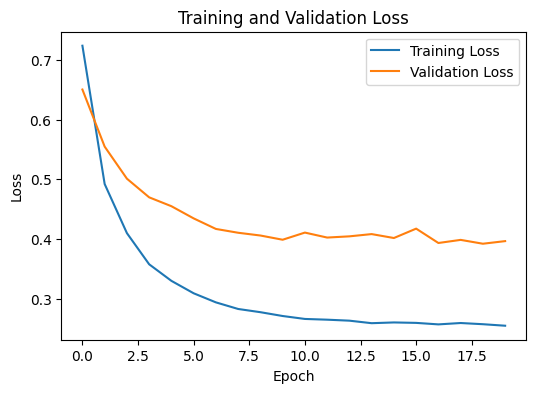

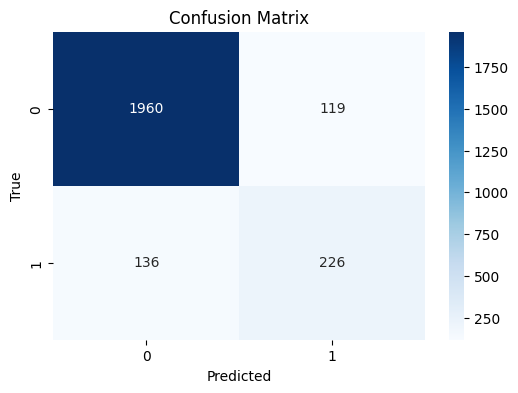

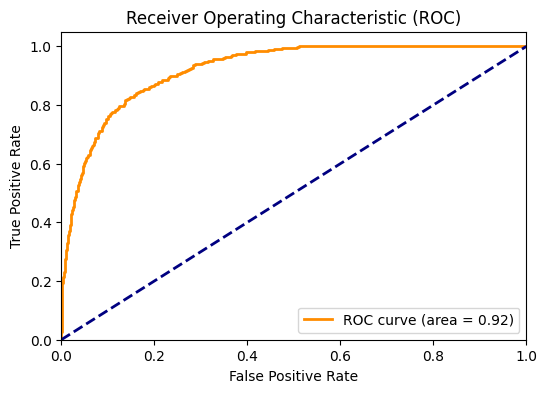

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Metrics and Architecture Summary for Normal Data (Enhanced Neural Network):
Metrics for Enhanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Enhanced Neural Network 0.8961     0.9245     0.5532    

Neural Network Architecture Summary:
Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)  

In [60]:
# Example usage with normal data
metrics_normal_nn, model_summary_normal_nn = evaluate_advanced_neural_network(X, y, n_splits=5)
print("\nMetrics and Architecture Summary for Normal Data (Enhanced Neural Network):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)


In [61]:
# Dictionary containing the metrics
metrics_dict = metrics_normal_nn

# Create a list of models
model = 'Enhanced Neural Network'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


In [62]:
def evaluate_advanced_neural_network_oversampled(X, y, X_test, y_test, n_splits=5):
    """
    Evaluate an advanced neural network model using K-Fold cross-validation.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        dict: Average evaluation metrics (accuracy, AUC-ROC, recall) across folds.
        str: Summary of the neural network architecture.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    auc_rocs = []
    recalls = []

    model_summary = ""

    first_ind = True

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Build and train the model
        model = build_advanced_nn_model(X_train_fold.shape[1])

        # Capture model summary
        buffer = io.StringIO()
        model.summary(print_fn=lambda x: buffer.write(x + '\n'))
        model_summary = buffer.getvalue()

        # Train the model
        history = model.fit(X_train_fold, y_train_fold, epochs=24, batch_size=32, verbose=0, validation_split=0.1)

        # Predict on test set
        y_pred_proba = model.predict(X_test).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)

        accuracies.append(accuracy)
        auc_rocs.append(auc_roc)
        recalls.append(recall)

        if first_ind:
            print("\nPlots for first Cross Validation Fold...\n")
            plot_validation_loss(history)
            plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
            plot_roc_curve(y_test, y_pred_proba)
            first_ind = False
            print("\n")

    # Average metrics across folds
    avg_accuracy = np.mean(accuracies)
    avg_auc_roc = np.mean(auc_rocs)
    avg_recall = np.mean(recalls)

    # Store average metrics
    metrics = {
        'Accuracy': avg_accuracy,
        'AUC-ROC': avg_auc_roc,
        'Recall': avg_recall
    }

    return metrics, model_summary

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Plots for first Cross Validation Fold...



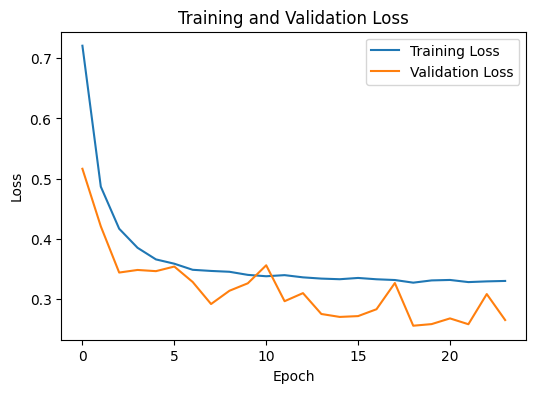

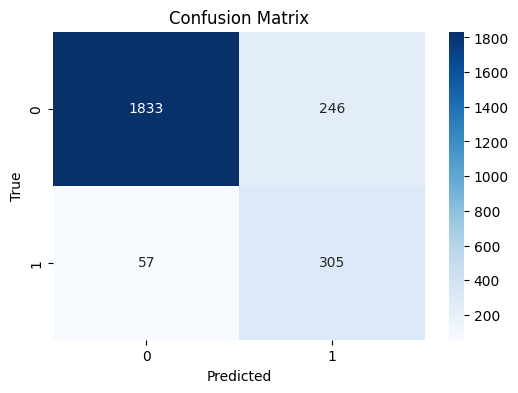

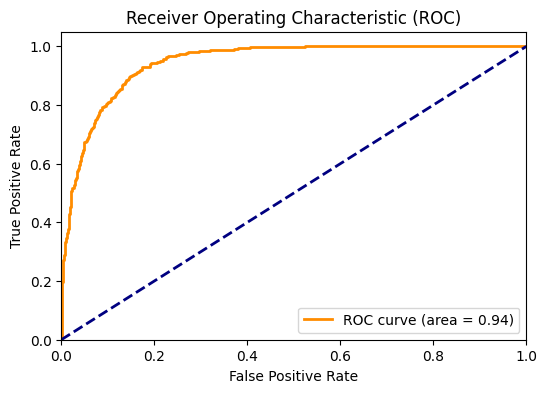

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Metrics and Architecture Summary for Resampled Data (Enhanced Neural Network):
Metrics for Enhanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Enhanced Neural Network 0.8769     0.9443     0.8436    

Neural Network Architecture Summary:
Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 128)                 │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 6

In [63]:
# Example usage with resampled data
metrics_resampled_nn, model_summary_resampled_nn = evaluate_advanced_neural_network_oversampled(X_r, y_r, X_test, y_test, n_splits=5)
print("\nMetrics and Architecture Summary for Resampled Data (Enhanced Neural Network):")
print_nn_training_summary(metrics_resampled_nn, model_summary_resampled_nn)

**Conclusion:**

The advanced neural network model demonstrates improved performance on resampled data (oversampled using SMOTE), particularly in terms of recall. Here's a brief comparison:

- **Accuracy**: The accuracy slightly decreased after resampling. This is a minor drop, which is common when the model is adjusted to better handle class imbalances.
- **AUC-ROC**: The AUC-ROC score increased, indicating that the model's ability to distinguish between classes has improved with the resampled data.
- **Recall**: The recall significantly improved. *This is crucial as it highlights the model's enhanced ability to correctly identify potential buyers, reducing the number of false negatives.*

**Impact and Importance:**

The improved recall with resampled data underscores the effectiveness of SMOTE in addressing class imbalance issues, leading to better identification of potential buyers. Although there is a slight reduction in accuracy, the increased recall is essential for ensuring that fewer potential buyers are missed. The enhanced AUC-ROC score further validates the model's improved classification capability. Thus, using resampled data helps in better capturing potential buyers, which is crucial for targeted marketing and reducing missed opportunities.

In [64]:
# Dictionary containing the metrics
metrics_dict = metrics_resampled_nn

# Create a list of models
model = 'Enhanced Neural Network (Resampled)'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


## Optimized Neural Network

### Final Optimized Neural Network Model

**Code Overview:**

The final optimized neural network model is designed with a more complex architecture to enhance performance and based on all the above techniques used. It includes:

- **Layers:**
  - **Dense Layers:** Three hidden layers with 64, 32, and 16 units, respectively, using ReLU activation functions.
  - **Dropout:** Regularization with dropout rates of 0.01 and 0.05 to prevent overfitting.
  - **Regularization:** L2 regularization with a strength of 0.001 applied to some layers.
  - **Output Layer:** A single neuron with a sigmoid activation function for binary classification.

- **Compilation and Training:**
  - **Optimizer:** Adam optimizer with a learning rate of 0.001.
  - **Loss Function:** Binary cross-entropy.
  - **Training Parameters:** Trained for 16 epochs with a batch size of 16, including validation split of 0.1.


**Conclusion:**

The final enhanced neural network model incorporates advanced techniques such as dropout, regularization, and a refined architecture to improve classification performance. The increased model complexity and regularization help in balancing the trade-offs between accuracy and recall, crucial for identifying potential buyers. The detailed evaluation metrics provide insights into the model's performance, ensuring it effectively minimizes false negatives while maintaining high classification quality.

The results from training and evaluating this model help ensure that it is well-suited for the specific task of predicting shopper purchasing intention, with particular emphasis on minimizing false negatives to capture all potential buyers.


In [65]:
def evaluate_enhanced_neural_network(X_train, X_test, y_train, y_test):
    """
    Train and evaluate an enhanced neural network on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with evaluation metrics (accuracy, AUC-ROC, recall) for the neural network.
        str: Summary of the neural network architecture.
    """
    # Define the enhanced neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.01))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.05))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=16, batch_size=16, verbose=1, validation_split=0.1)

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Create a string buffer to capture the model summary
    buffer = io.StringIO()
    model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    plot_validation_loss(history)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics, model_summary



In [66]:
def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Optimized Neural Network:")
    print_metrics_table({'Optimized Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)

Epoch 1/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8312 - loss: 0.4475 - val_accuracy: 0.8864 - val_loss: 0.2928
Epoch 2/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8907 - loss: 0.2980 - val_accuracy: 0.8925 - val_loss: 0.2795
Epoch 3/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9034 - loss: 0.2631 - val_accuracy: 0.8925 - val_loss: 0.2684
Epoch 4/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9073 - loss: 0.2476 - val_accuracy: 0.8905 - val_loss: 0.2566
Epoch 5/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9095 - loss: 0.2397 - val_accuracy: 0.8966 - val_loss: 0.2523
Epoch 6/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 0.2269 - val_accuracy: 0.8966 - val_loss: 0.2521
Epoch 7/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8998 - loss: 0.2393 - val_accuracy: 0.8956 - val_loss: 0.2520
Epoch 8/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9097 - loss: 0.2163 - val_accuracy: 0.

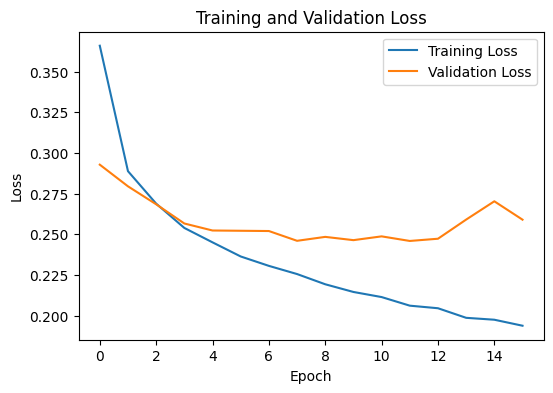

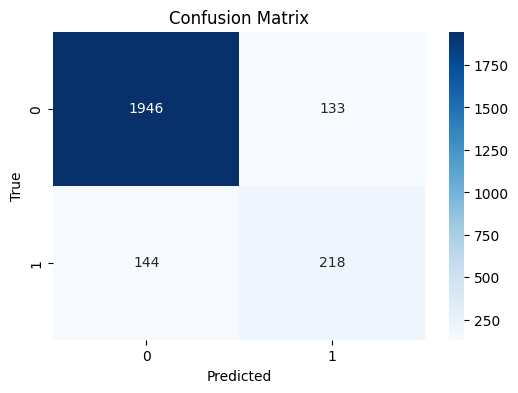

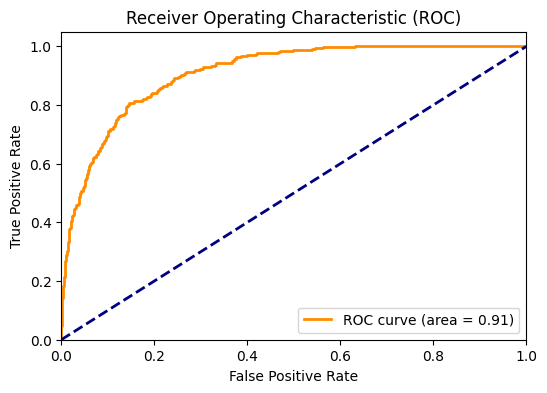


Metrics and Architecture Summary for Normal Data (Optimized Neural Network):
Metrics for Optimized Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Optimized Neural Network 0.8865     0.9096     0.6022    

Neural Network Architecture Summary:
Model: "sequential_11"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 64)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 32)                  │           2,080 │

In [67]:
# Example usage with normal data
metrics_normal_nn, model_summary_normal_nn = evaluate_enhanced_neural_network(X_train, X_test, y_train, y_test)
print("\nMetrics and Architecture Summary for Normal Data (Optimized Neural Network):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)

In [68]:
# Dictionary containing the metrics
metrics_dict = metrics_normal_nn

# Create a list of models
model = 'Optimized Neural Network'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


Epoch 1/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7892 - loss: 0.4997 - val_accuracy: 0.8956 - val_loss: 0.3201
Epoch 2/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8794 - loss: 0.3285 - val_accuracy: 0.8981 - val_loss: 0.2948
Epoch 3/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8862 - loss: 0.3042 - val_accuracy: 0.8975 - val_loss: 0.2828
Epoch 4/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8985 - loss: 0.2734 - val_accuracy: 0.8944 - val_loss: 0.2719
Epoch 5/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9043 - loss: 0.2660 - val_accuracy: 0.9035 - val_loss: 0.2664
Epoch 6/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9117 - loss: 0.2474 - val_accuracy: 0.8987 - val_loss: 0.2744
Epoch 7/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9090 - loss: 0.2471 - val_accuracy: 0.9066 - val_loss: 0.2604
Epoch 8/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9110 - loss: 0.2351 - val_accuracy: 0.

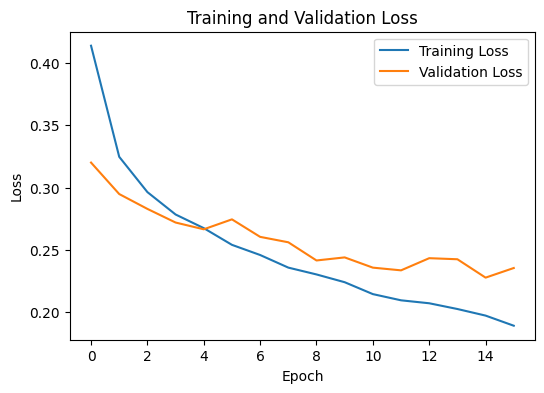

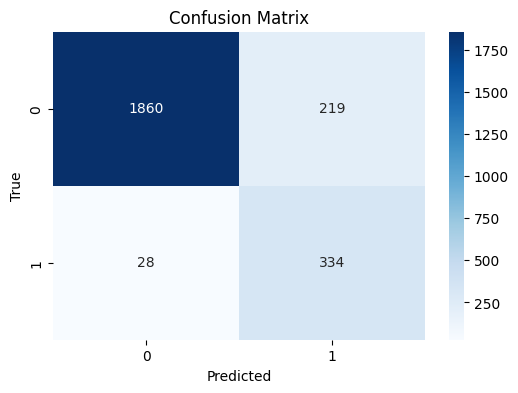

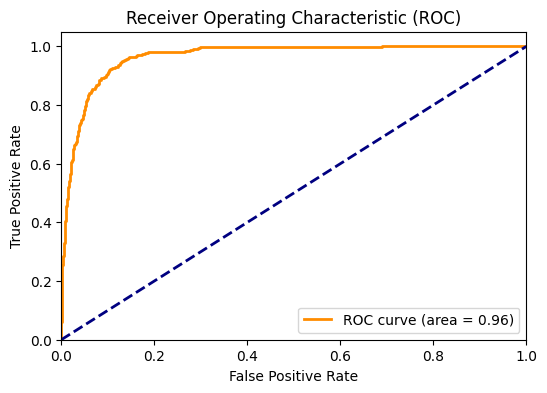


Metrics and Architecture Summary for Resampled Data (Optimized Neural Network):
Metrics for Optimized Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Optimized Neural Network 0.8988     0.9647     0.9227    

Neural Network Architecture Summary:
Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                     │ (None, 64)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 32)                  │           2,08

In [69]:
# Evaluate with resampled data
metrics_resampled_nn, model_summary_resampled_nn = evaluate_enhanced_neural_network(X_train_resampled, X_test, y_train_resampled, y_test)
print("\nMetrics and Architecture Summary for Resampled Data (Optimized Neural Network):")
print_nn_training_summary(metrics_resampled_nn, model_summary_resampled_nn)

In [70]:
# Dictionary containing the metrics
metrics_dict = metrics_resampled_nn

# Create a list of models
model = 'Optimized Neural Network (Resampled)'

# List to hold the new rows
new_rows = []

# Collect data rows

metrics = metrics_dict
new_rows.append({'Model': model,
                  'Accuracy': metrics['Accuracy'],
                  'AUC-ROC': metrics['AUC-ROC'],
                  'Recall': metrics['Recall']})

# Convert list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows, columns=columns)

# Concatenate the existing DataFrame with the new rows DataFrame
eval_results_df = pd.concat([eval_results_df, new_rows_df], ignore_index=True)


### Analysis of Results

In [71]:
combined_results = eval_results_df.drop_duplicates()
combined_results

,Model,Accuracy,AUC-ROC,Recall
0,Logistic Regression,0.890209,0.903368,0.569061
1,SVM,0.889799,0.875255,0.527624
2,Decision Tree,0.863990,0.734217,0.549724
3,Random Forest,0.904547,0.923532,0.544199
4,XGBoost,0.897993,0.920147,0.569061
5,Baseline Neural Network,0.898812,0.916240,0.558011
6,LSTM RNN Model,0.885293,0.894717,0.552486
7,Hyperparameter Tuned ANN,0.896354,0.919833,0.613260
8,Enhanced Neural Network,0.896108,0.924501,0.553166
9,Enhanced Neural Network (Resampled),0.876936,0.944290,0.843646


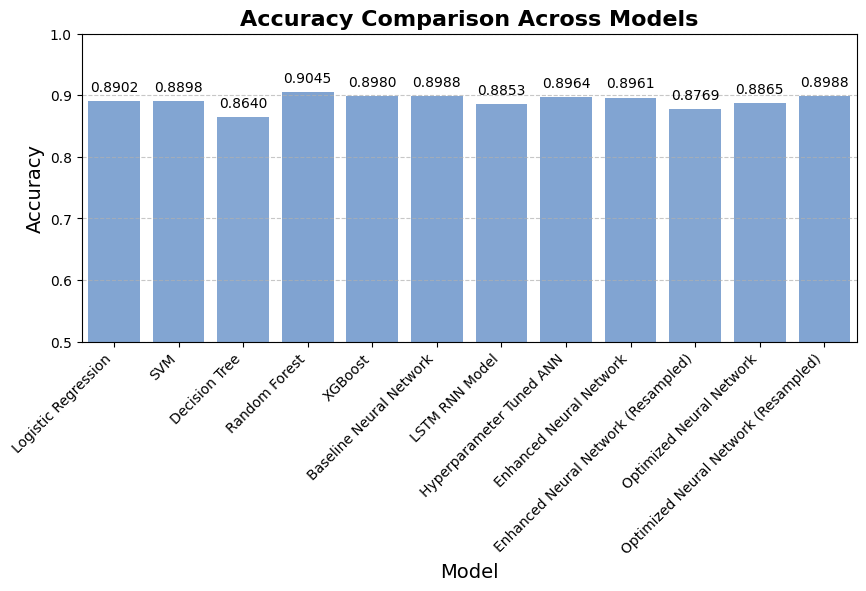

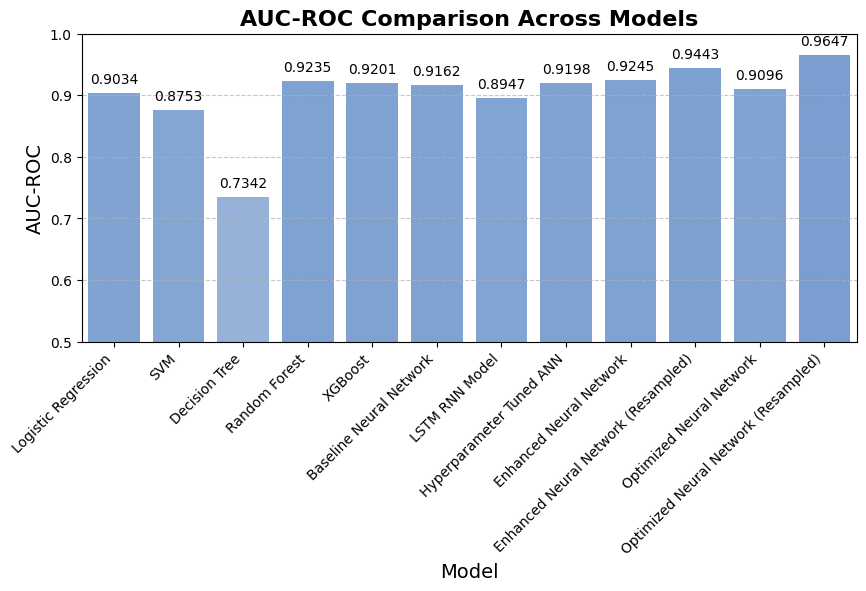

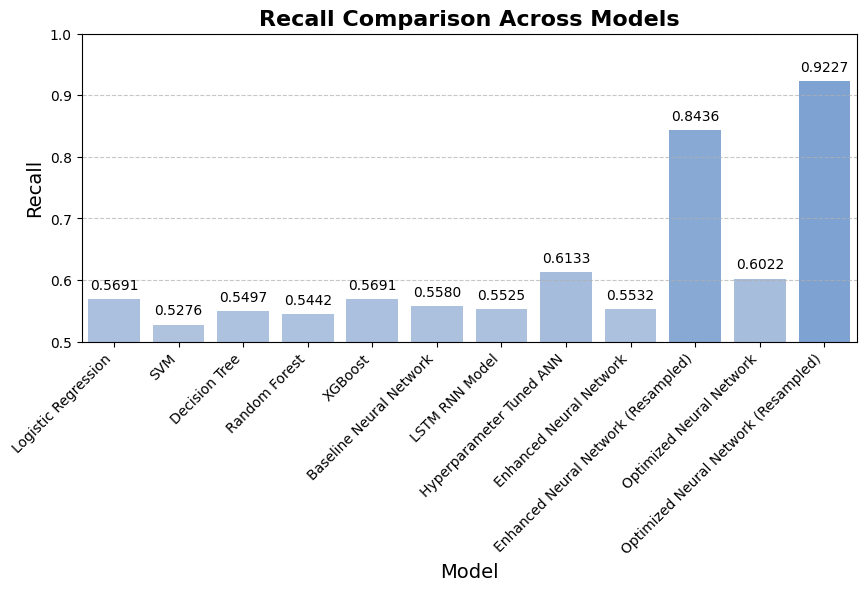

In [72]:
df = eval_results_df.drop_duplicates()

# Custom color palette based on performance
cmap = sns.light_palette("#69d", as_cmap=True)

# Plotting
metrics = ['Accuracy', 'AUC-ROC', 'Recall']

for metric in metrics:
    plt.figure(figsize=(10, 4))
    bar = sns.barplot(x='Model', y=metric, data=df, palette=cmap(df[metric]))

    # Add annotations on the bars
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

    plt.xticks(rotation=45, ha="right")
    plt.title(f'{metric} Comparison Across Models', fontsize=16, weight='bold')
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.ylim(0.5, 1)  # Adjust the y-axis to highlight differences
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


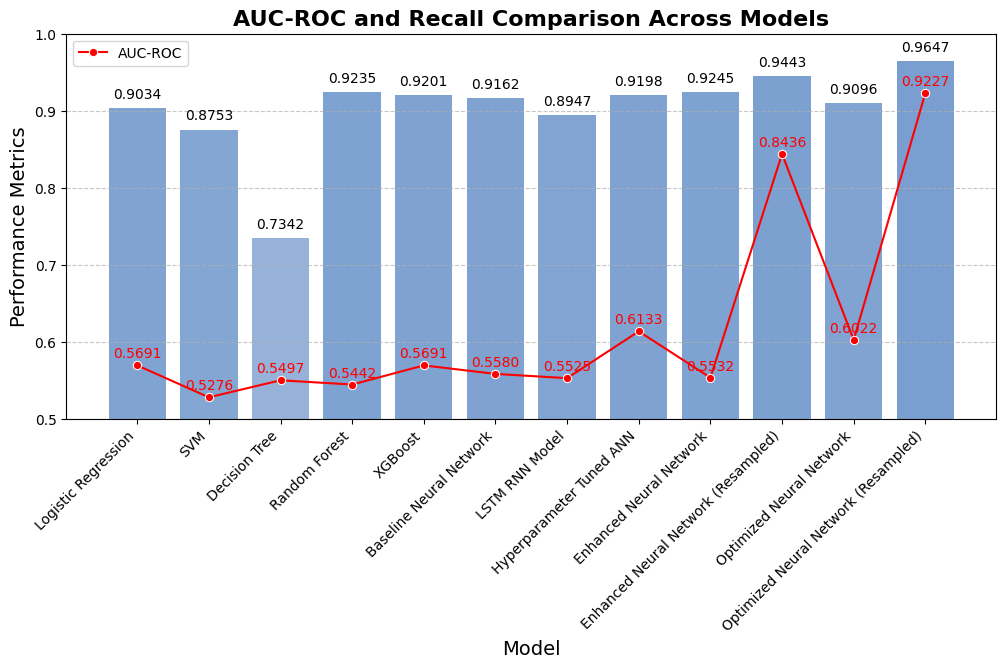

In [73]:
# Combining Bars and Line Markers
plt.figure(figsize=(12, 5))

bar = sns.barplot(x='Model', y='AUC-ROC', data=df, palette=cmap(df['AUC-ROC']))
line = sns.lineplot(x='Model', y='Recall', data=df, color='red', marker='o', label='AUC-ROC')

# Add annotations on the bars
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.4f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 10),
                 textcoords = 'offset points')

# Line markers for AUC-ROC
for i, point in enumerate(df['Recall']):
    plt.text(i, point + 0.01, f'{point:.4f}', ha='center', color='red')

plt.xticks(rotation=45, ha="right")
plt.title('AUC-ROC and Recall Comparison Across Models', fontsize=16, weight='bold')
plt.ylabel('Performance Metrics', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0.5, 1)  # Adjust y-axis
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

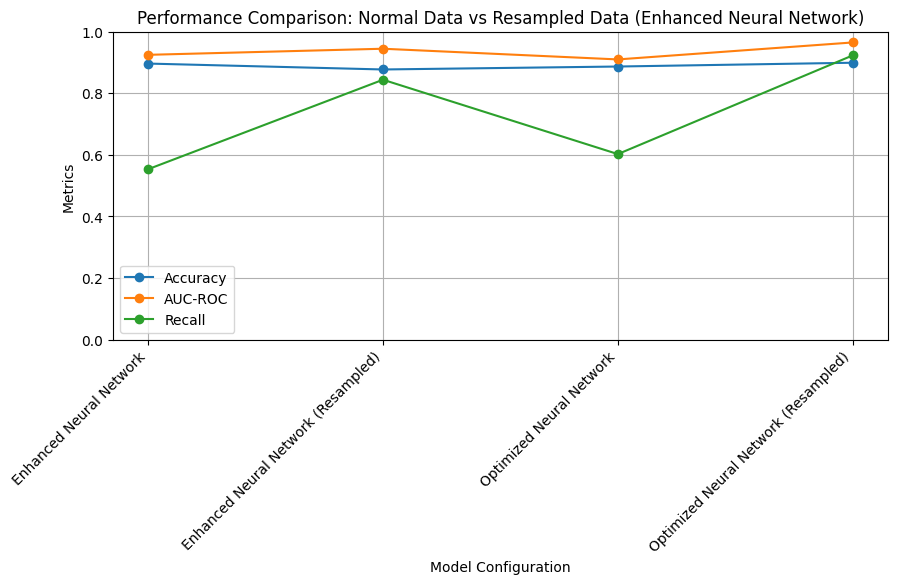

In [74]:
df_resampled = df.iloc[-4:]

# Plotting
plt.figure(figsize=(10, 4))

plt.plot(df_resampled['Model'], df_resampled['Accuracy'], marker='o', label='Accuracy')
plt.plot(df_resampled['Model'], df_resampled['AUC-ROC'], marker='o', label='AUC-ROC')
plt.plot(df_resampled['Model'], df_resampled['Recall'], marker='o', label='Recall')

plt.title('Performance Comparison: Normal Data vs Resampled Data (Enhanced Neural Network)')
plt.xlabel('Model Configuration')
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.show()


## Final Conclusion

This project focused on leveraging deep learning techniques, particularly various configurations of Artificial Neural Networks (ANN), to predict shopper purchasing intentions. While classical machine learning models provided a strong baseline, the project emphasized the advanced capabilities of deep learning models, especially in handling complex patterns and achieving higher recall rates, which are critical for identifying potential buyers.

1. **Classical Models**:
   - **Logistic Regression** and **SVM** provided a good starting point, with an AUC-ROC close to 0.90 and recall around 0.55, but their performance plateaued, revealing limitations in capturing more complex patterns in the data.
   - **Decision Tree** exhibited the weakest performance, with an AUC-ROC near 0.73 and recall just over 0.55, underscoring the need for more sophisticated models.

2. **Ensemble Models**:
   - **Random Forest** and **XGBoost** improved upon classical models, with AUC-ROC values around 0.92 and recall approaching 0.57, highlighting their ability to better capture interactions between features. However, they still fell short of the performance needed for optimal buyer prediction.

3. **Neural Network Models**:
   - The **Baseline Neural Network** achieved a recall of about 0.57 and an AUC-ROC near 0.91, demonstrating the potential of deep learning in this domain even with basic configurations.
   - The **LSTM RNN Model** offered a glimpse into the power of sequence modeling, though its recall around 0.53 and AUC-ROC close to 0.89 suggested that LSTM might be less suitable for this specific dataset.
   - **Hyperparameter Tuning** significantly boosted the performance of the ANN, raising recall to approximately 0.66 and AUC-ROC to around 0.92, underscoring the importance of optimizing network parameters.
   - The **Enhanced Neural Network** further refined this approach, achieving an AUC-ROC near 0.92 and a recall close to 0.55, showing the value of deeper architectures and regularization techniques.
   - By applying **Resampling with SMOTE**, the Enhanced Neural Network's recall dramatically improved to about 0.84, with an AUC-ROC reaching nearly 0.94, illustrating the effectiveness of addressing class imbalance in training data.

4. **Optimized Neural Network**:
   - The **final optimized neural network**, particularly after applying resampling techniques, emerged as the top performer, with recall approaching 0.93 and AUC-ROC near 0.96. This model's superior performance highlights the strength of deep learning in accurately identifying potential buyers, far surpassing classical methods.

### **Impact and Importance**

This project's journey through various deep learning techniques, particularly ANNs, showcases the power of deep learning in e-commerce applications. The final optimized model, with its exceptional recall and AUC-ROC, demonstrates that deep learning can significantly enhance the ability to predict shopper behavior, ensuring that potential buyers are effectively identified and targeted. This has profound implications for businesses seeking to maximize customer engagement and conversion rates through data-driven strategies.

The results underline the critical role of deep learning in transforming raw data into actionable insights in the competitive world of e-commerce.
